In [2]:
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [3]:
def transform_cabin( cabin_nb ):
    
#    print('This is print:', cabin_nb)
    deck, num, side = cabin_nb.split('/')
    
    num = int(num)
    
    if side == 'P':
        side = 0
        
    else:
        side = 1
    
    return([deck, num, side])

def transform_side( cabin_nb ):
    
    side = cabin_nb.split('/')[2]
    
    if side == 'P':
        side = 1
    
    elif side == 'S':
        side = -1
    
    else:
        side = 0
        
    return side

In [4]:
data = pd.read_csv('data/train.csv')


y = data['Transported']
X = data.drop(['Transported'], axis=1)

X['CryoSleep'].value_counts()
X['HomePlanet'].value_counts()
X['VIP'].value_counts()

# I drop the name because most of them appear once (why are there some which appear more often?)
# If no grouping after name is done it should be random. For first try this is good enough.

X = X.drop(['Name'], axis = 1)
#

# I use false as filler for nan because false is the most frequent
X['CryoSleep'] = (X['CryoSleep'].fillna(False)).astype(int)
X['VIP'] = (X['VIP'].fillna(False)).astype(int)
X['HomePlanet'] = X['HomePlanet'].fillna('Earth')

X['PassengerId'] = X['PassengerId'].map(lambda ID: int(ID.split('_')[0]))

# There are 3 home origins. Take one hot encoding

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X[['HomePlanet', 'Destination']]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X.index

# Remove categorical columns (will replace with one-hot encoding)
num_X = X.drop(['HomePlanet', 'Destination'], axis=1)

# Add one-hot encoded columns to numerical features
X = pd.concat([num_X, OH_cols_train], axis=1)

    
X['Cabin'] = X['Cabin'].fillna('U/-1/U')

X['Floor'] = X['Cabin'].apply(lambda cabin_nb: cabin_nb.split('/')[0])
X['Seat']  = X['Cabin'].apply(lambda cabin_nb: int(cabin_nb.split('/')[1]))
X['Side']  = X['Cabin'].apply(transform_side)
X = X.drop(['Cabin'], axis=1)

Normalize_col = ['PassengerId', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Seat']
X[Normalize_col] = X[Normalize_col] / X[Normalize_col].max()



# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
X['Floor'] = ordinal_encoder.fit_transform(X[['Floor']])

services = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
X[services] = X[services].fillna(0)
X = X.fillna(0)

/home/philipp/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
X.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,0,1,2,3,4,5,6,Floor,Seat,Side
0,0.000108,0,0.493671,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,1
1,0.000216,0,0.303797,0,0.007608,0.000302,0.001064,0.024500,0.001823,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.000000,-1
2,0.000323,0,0.734177,1,0.003001,0.119948,0.000000,0.299670,0.002030,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,-1
3,0.000323,0,0.417722,0,0.000000,0.043035,0.015793,0.148563,0.007997,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,-1
4,0.000431,0,0.202532,0,0.021149,0.002348,0.006428,0.025214,0.000083,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.000528,-1


In [41]:
import numpy as np
print(X['ShoppingMall'].head())

test = np.log(X['ShoppingMall']+1)
test.head()

0    0.000000
1    0.001064
2    0.000000
3    0.015793
4    0.006428
Name: ShoppingMall, dtype: float64


0    0.000000
1    0.001064
2    0.000000
3    0.015669
4    0.006407
Name: ShoppingMall, dtype: float64

In [44]:
np.log(0.001064+1)

0.0010634343531965307

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    
    layers.Dense(19, activation='relu', input_shape=[19,]),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    #layers.Dense(19, activation='relu', input_shape=[19,]),
    #layers.Dropout(0.3),
    #layers.Dense(12, activation='relu', input_shape=[19,]),
    #layers.Dropout(0.3),
    layers.Dense(10, activation='relu', input_shape=[19,]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(5, activation='relu', input_shape=[19,]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid', input_shape=[19,]),

])

#

In [24]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks


early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=40, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

history = model.fit(X_train, y_train, validation_data=[X_test, y_test],
                batch_size=310,
                epochs=2000,
                #callbacks=[early_stopping],
                verbose=0    
                   )

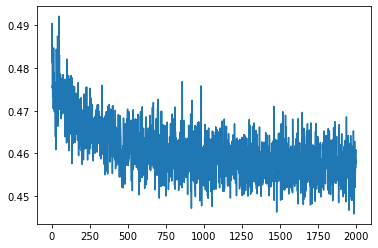

In [25]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();

print(X_train.shape)
X_test.shape

In [26]:
from sklearn.metrics import balanced_accuracy_score

preds = (model.predict(X_test) > 0.5).astype('int32')
bacc_nn = balanced_accuracy_score(y_test, preds)
bacc_nn

90/90 [==============================] - 0s 437us/step


0.786265600093309

In [27]:
X_valid = pd.read_csv('data/test.csv')


# I drop the name because most of them appear once (why are there some which appear more often?)
# If no grouping after name is done it should be random. For first try this is good enough.

X_valid = X_valid.drop(['Name'], axis = 1)
#

# I use false as filler for nan because false is the most frequent
X_valid['CryoSleep'] = (X_valid['CryoSleep'].fillna(False)).astype(int)
X_valid['VIP'] = (X_valid['VIP'].fillna(False)).astype(int)
X_valid['HomePlanet'] = X_valid['HomePlanet'].fillna('Earth')

X_valid['PassengerId'] = X_valid['PassengerId'].map(lambda ID: int(ID.split('_')[0]))

In [195]:
# There are 3 home origins. Take one hot encoding

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_valid[['HomePlanet', 'Destination']]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_valid = X_valid.drop(['HomePlanet', 'Destination'], axis=1)

# Add one-hot encoded columns to numerical features
X_valid = pd.concat([num_X_valid, OH_cols_train], axis=1)

/home/philipp/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [196]:
    
X_valid['Cabin'] = X_valid['Cabin'].fillna('U/-1/U')

X_valid['Floor'] = X_valid['Cabin'].apply(lambda cabin_nb: cabin_nb.split('/')[0])
X_valid['Seat']  = X_valid['Cabin'].apply(lambda cabin_nb: int(cabin_nb.split('/')[1]))
X_valid['Side']  = X_valid['Cabin'].apply(transform_side)
X_valid = X_valid.drop(['Cabin'], axis=1)

In [197]:
Normalize_col = ['PassengerId', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Seat']
X_valid[Normalize_col] = X_valid[Normalize_col] / X_valid[Normalize_col].max()

In [198]:
# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
X_valid['Floor'] = ordinal_encoder.fit_transform(X_valid[['Floor']])

services = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
X_valid[services] = X_valid[services].fillna(0)
X_valid = X_valid.fillna(0)

In [200]:
preds = (model.predict(X_valid) > 0.5).astype(int)

# Sample submission (to get right format)
sub=pd.read_csv('data/sample_submission.csv')
sub.head()

134/134 [==============================] - 0s 355us/step


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [203]:
# Sample submission (to get right format)
sub=pd.read_csv('data/sample_submission.csv')

# Add predictions
sub['Transported'] = preds

# Replace 0 to False and 1 to True
sub=sub.replace({0:False, 1:True})

# Prediction distribution
#plt.figure(figsize=(6,6))
#sub['Transported'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Prediction distribution")
# Output to csv
sub.to_csv('submission.csv', index=False)

In [204]:
preds

array([[0],
       [0],
       [1],
       ...,
       [1],
       [1],
       [1]])